In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime
from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn import preprocessing, cross_validation, svm

%matplotlib inline
# plt.style.use('ggplot')

C:\Users\MattS\Anaconda3\envs\tfdeeplearning\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# HELPER FUNCTIONS

In [2]:
def read_data(file_path, column_names):
    """Reads the data from the specified file and retrieves the column names
    
    Args:
        file_path: The path of the file as a String
        column_names: Array of Strings representing the names of the colunms
        
    Returns:
        A DataFrame of the read in data
    """
    data = pd.read_csv(file_path, header = 0, names = column_names)
    return data

def feature_normalize(dataset):
    """Normalizes the data in the DataFrame using the mean and sigma values
    
    Args:
        dataset: The DataFrame to normalize
        
    Returns:
        The normalized data
    """
    mu = np.mean(dataset, axis = 0)
    sigma = np.std(dataset, axis = 0)
    return (dataset - mu) / sigma

def basic_feature_normalize(dataset, cols_to_norm):
    """A Basic Normalization of the dataset
    
    Takes the dataset and normalizes it from 0 (min value) to 1 (max value)
    
    Args:
        dataset: The DataFrame to normalize
        cols_to_norm: An Array of strings of the columns that need normalization
        
    Returns:
        The normalized dataset with the specified columns normalized between 0 and 1
    """
    dataset[cols_to_norm] = dataset[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    return dataset

def make_rgbs(dataset, cols_to_rgb):
    """Takes a dataset and converts specific columns into rgb values
    
    Args:
        dataset: The DataFrame to convert to rgb values
        cols_to_rgb: An Arrya of strings of the columns that need to be converted
        
    Returns:
        The dataset with the specified columns converted to rgb values
    """
    dataset[cols_to_rgb] = dataset[cols_to_rgb].apply(lambda x: int(x * 255))
    return dataset

def convert_timestamp(dataset):
    """Converts the timestamp to a unix timestamp
    
    Args:
        dataset: The DataFrame with the timestamp column to convert to unix
        
    Returns:
        The dataset with the converted timestamp
    """
    dataset['Timestamp'] = dataset['Timestamp'].apply(lambda x:
                                                     datetime.strptime(x, '%m/%d/%y %H:%M').timestamp())
    return dataset

def convert_BGA_RFU(dataset, threshold):
    """Converts the BGA_Phycocyanin_RFU column to a true or false value (represented by 1 or 0)
       based on the threshold value
       
    Args:
        dataset: The DataFrame with the BGA_Phycocyanin_RFU value to be adjusted
        threshold: The minimum value for an algae bloom to be true
        
    Returns:
        The dataset with the converted BGA_RFU value"""
    dataset['BGA_Phycocyanin_RFU'] = dataset['BGA_Phycocyanin_RFU'].apply(lambda x: 1 if x >= threshold else 0)
    return dataset

# Batch Creation

In [3]:
# We step 50% down based on window size
def windows(data, size):
    counter_output = 0
    start = 0
    while start < data.count():
        yield int(start), int(start + size)
        start += (size / 12)
        counter_output += 1
        if counter_output % 10 == 0:
            print('Window Segmentation {0:.2f}% done'.format((start / data.count()) * 100))
    
# 32 chosen for 8 hours of 15 minute intervals
# TODO: NEED TO PASS IN COLUMNS AND DETERMINE FROM THAT
def segment_signal(dataset, window_size = 90, columns = 5):
    segments = np.empty((0, window_size, columns))
    labels = np.empty((0))
    count = 0;
    for (start, end) in windows(dataset["Timestamp"], window_size):
        temperature = dataset['Temperature'][start:end]
        conductivity = dataset['Sp_Cond'][start:end]
        turbidity = dataset['Turbidity'][start:end]
#         ph = dataset['pH'][start:end]
        odo = dataset['ODO'][start:end]
        if(len(dataset['Timestamp'][start:end]) == window_size):
            segments = np.vstack([segments, np.dstack([temperature, conductivity, turbidity, odo])])
            labels = np.append(labels, stats.mode(dataset['BGA_Phycocyanin_RFU'][start:end])[0][0])
    return segments, labels

# Setup the Lake_Dataset

In [4]:
cols = ['Temperature', 'Sp_Cond', 'pH_mV', 'pH', 'Turbidity', 'Chlorophyll', 'Chlorophyll_RFU',
        'ODOSat', 'ODO', 'BGA_Phycocyanin_RFU']

cols_to_keep = []
cols_to_keep.append('Temperature')
# cols_to_keep.append('Sp_Cond')
# cols_to_keep.append('pH_mV')
# cols_to_keep.append('pH')
# cols_to_keep.append('Turbidity')
# cols_to_keep.append('Chlorophyll')
# cols_to_keep.append('Chlorophyll_RFU')
# cols_to_keep.append('ODOSat')
# cols_to_keep.append('ODO')
# cols_to_keep.append('BGA_Phycocyanin_RFU')

lake_dataset = read_data('./data/cleaned/bird_lake_combined_no_timestamp.csv', cols) 

for col in cols:
    if col not in cols_to_keep:
        lake_dataset = lake_dataset.drop(col, axis=1)
        
lake_dataset.head()

,Temperature
0,23.19
1,22.98
2,22.99
3,22.98
4,22.96


In [6]:
forecast_out = int(300)
lake_dataset['Prediction'] = lake_dataset[['Temperature']].shift(-forecast_out)

In [7]:
lake_dataset.head()

,Temperature,Prediction
0,23.19,24.16
1,22.98,24.48
2,22.99,24.48
3,22.98,24.36
4,22.96,24.22


In [8]:
lake_dataset.tail()

,Temperature,Prediction
32565,5.76,NaN
32566,5.72,NaN
32567,5.69,NaN
32568,5.68,NaN
32569,5.63,NaN


In [9]:
X = np.array(lake_dataset.drop(['Prediction'], 1))
X = preprocessing.scale(X)

In [10]:
X_forecast = X[-forecast_out:]
X = X[:-forecast_out]

In [11]:
y = np.array(lake_dataset['Prediction'])
y = y[:-forecast_out]

In [12]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size= 0.3)

In [13]:
clf = LinearRegression()
clf.fit(X_train, y_train)

confidence = clf.score(X_test, y_test)
print("confidence: ", confidence)

confidence:  0.929863599951


In [14]:
X_forecast

array([[-1.79285862],
       [-1.79440724],
       [-1.79750447],
       [-1.79440724],
       [-1.79595585],
       [-1.79905308],
       [-1.80524754],
       [-1.80524754],
       [-1.80679616],
       [-1.80989339],
       [-1.811442  ],
       [-1.81299061],
       [-1.81299061],
       [-1.81299061],
       [-1.81453923],
       [-1.81608784],
       [-1.81608784],
       [-1.81763646],
       [-1.81763646],
       [-1.81608784],
       [-1.81453923],
       [-1.81453923],
       [-1.81299061],
       [-1.811442  ],
       [-1.80989339],
       [-1.80834477],
       [-1.80524754],
       [-1.8006017 ],
       [-1.79595585],
       [-1.79131001],
       [-1.78821278],
       [-1.78201832],
       [-1.75414325],
       [-1.77737248],
       [-1.76808079],
       [-1.73555988],
       [-1.74330295],
       [-1.73865711],
       [-1.73246265],
       [-1.73865711],
       [-1.71233066],
       [-1.73091403],
       [-1.73555988],
       [-1.70458758],
       [-1.6534833 ],
       [-1

In [15]:
forecast_prediction = clf.predict(X_forecast)
print(forecast_prediction)

[ 6.89270604  6.88293104  6.86338104  6.88293104  6.87315604  6.85360604
  6.81450605  6.81450605  6.80473105  6.78518105  6.77540605  6.76563105
  6.76563105  6.76563105  6.75585605  6.74608105  6.74608105  6.73630606
  6.73630606  6.74608105  6.75585605  6.75585605  6.76563105  6.77540605
  6.78518105  6.79495605  6.81450605  6.84383104  6.87315604  6.90248104
  6.92203103  6.96113103  7.13708101  6.99045603  7.04910602  7.254381
  7.205506    7.234831    7.27393099  7.234831    7.40100598  7.28370599
  7.254381    7.44988097  7.77245594  7.75290594  7.50853097  7.51830597
  7.59650596  7.71380594  7.69425595  7.67470595  7.62583095  7.72358094
  7.62583095  7.75290594  7.72358094  7.71380594  7.85065593  7.83110593
  7.78223094  7.66493095  7.51830597  7.49875597  7.45965597  7.44988097
  7.44010597  7.43033098  7.42055598  7.42055598  7.41078098  7.40100598
  7.40100598  7.40100598  7.39123098  7.39123098  7.39123098  7.38145598
  7.38145598  7.37168098  7.37168098  7.36190598  7.3

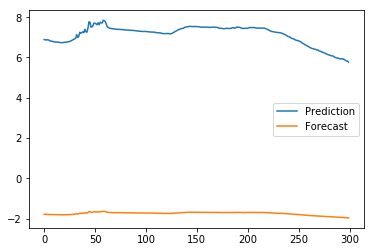

In [17]:
plt.plot(forecast_prediction, label="Prediction")
plt.plot(X_forecast, label="Forecast")
plt.legend()